In [17]:
%matplotlib inline
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import *

In [145]:
"""
Even the simple XOR system has 8 dimensions of evolutions:
- This model does not always learn
- Highly depends on the initialization
- The minibatch is not helping here (not enough inputs: no estimation of gradient)
"""

class XORModelSoftmax(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(2, 2), nn.ReLU(), nn.Linear(2, 2))
        self.softmax = nn.Softmax(dim=-1)
        
    def init_weights(self):
        for module in self.model.modules():
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_normal_(module.weight)
    
    def forward(self, x, with_softmax=True):
        x = x.float()
        x = self.model(x)
        if with_softmax:
            x = self.softmax(x)
        return x

def train(xs, ys):
    data_set = TensorDataset(xs, ys)
    data_loader = DataLoader(data_set, batch_size=4, shuffle=True)

    model = XORModelSoftmax()
    model.init_weights()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-1)

    for epoch in range(1000):
        cumulative_loss = 0.
        for inputs, expected in data_loader:
            optimizer.zero_grad()
            got = model(inputs, with_softmax=False)
            loss = criterion(got, expected)
            loss.backward()
            optimizer.step()
            cumulative_loss += loss.item()
        if epoch % 100 == 0:
            print(cumulative_loss)
    return model

xs = torch.tensor([[0, 0], [1, 0], [0, 1], [1, 1]], dtype=torch.long, requires_grad=False)
ys = torch.tensor([0, 1, 1, 0], dtype=torch.long, requires_grad=False)
model = train(xs, ys)

0.7094878554344177
0.003522902727127075
0.0013992488384246826
0.0007776021957397461
0.0005016326904296875
0.00035318732261657715
0.0002639591693878174
0.0002047419548034668
0.00016415119171142578
0.00013449788093566895


In [149]:
def classify(model, xs):
    xs = torch.tensor(xs, dtype=torch.long, requires_grad=False)
    ys = model(xs, with_softmax=True)
    return torch.argmax(ys, dim=-1)

classify(model, [[0, 0], [1, 0], [0, 1], [1, 1]])

tensor([0, 1, 1, 0])

In [182]:
"""
Reducing the number of dimensions by using a simple Sigmoid, and BCELoss
"""

class XORModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(2, 2), nn.ReLU(), nn.Linear(2, 1))
        self.sigmoid = nn.Sigmoid()
        
    def init_weights(self):
        for module in self.model.modules():
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_normal_(module.weight)
    
    def forward(self, x, with_sigmoid=True):
        x = x.float()
        x = self.model(x)
        if with_sigmoid:
            x = self.sigmoid(x)
        else:
            x = x.squeeze(dim=-1)
        return x

def train(xs, ys):
    data_set = TensorDataset(xs, ys)
    data_loader = DataLoader(data_set, batch_size=4, shuffle=True)

    model = XORModel()
    model.init_weights()

    criterion = nn.BCEWithLogitsLoss() # Numerically stable version of nn.Sigmoid() + nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-1)

    for epoch in range(1000):
        cumulative_loss = 0.
        for inputs, expected in data_loader:
            optimizer.zero_grad()
            got = model(inputs, with_sigmoid=False)
            loss = criterion(got, expected)
            loss.backward()
            optimizer.step()
            cumulative_loss += loss.item()
        if epoch % 100 == 0:
            print(cumulative_loss)
    return model

xs = torch.tensor([[0, 0], [1, 0], [0, 1], [1, 1]], dtype=torch.long, requires_grad=False)
ys = torch.tensor([0, 1, 1, 0], dtype=torch.float, requires_grad=False)
model2 = train(xs, ys)

0.8597413897514343
0.009858980774879456
0.002891469281166792
0.0015433047665283084
0.0009799122344702482
0.000684225931763649
0.0005100297275930643
0.00039527477929368615
0.00031636847415938973
0.0002595887053757906


In [183]:
def classify(model, xs):
    xs = torch.tensor(xs, dtype=torch.long, requires_grad=False)
    ys = model(xs)
    return list(y.item() >= 0.5 for y in ys)

classify(model2, [[0, 0], [1, 0], [0, 1], [1, 1]])

[False, True, True, False]

X: layer 0 position (0, 0)
Y: layer 0 position (0, 1)


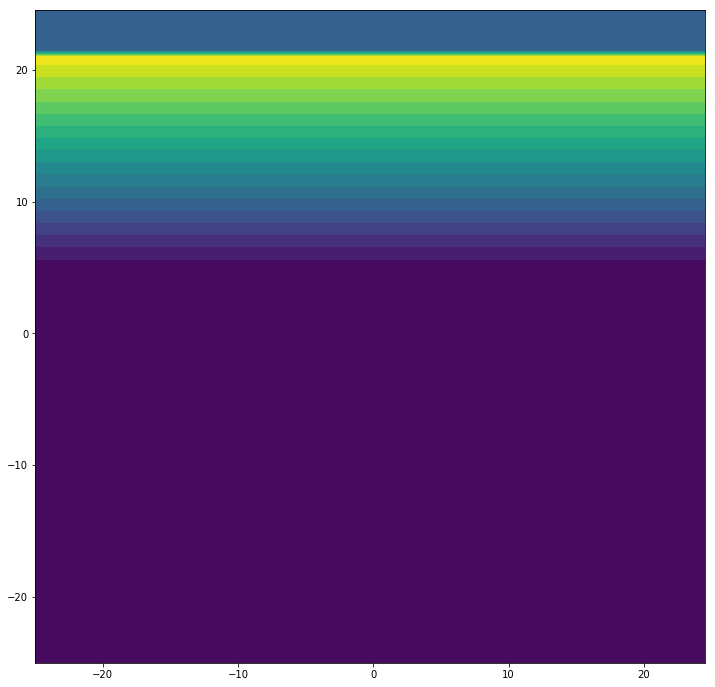

X: layer 0 position (0, 0)
Y: layer 0 position (1, 0)


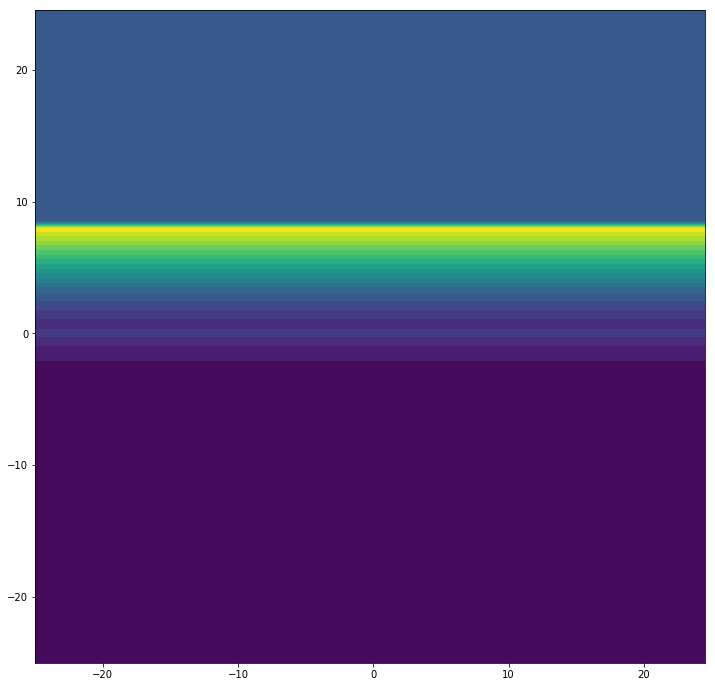

X: layer 0 position (0, 0)
Y: layer 0 position (1, 1)


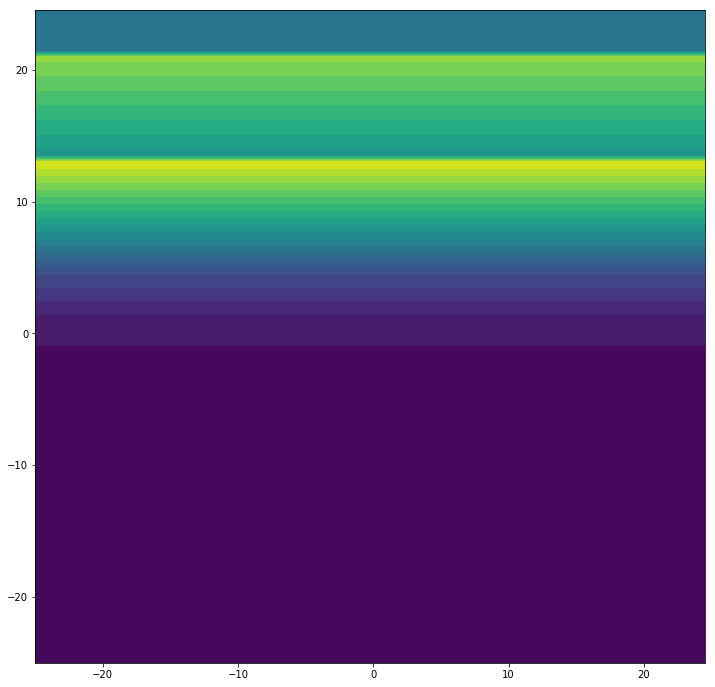

X: layer 0 position (0, 0)
Y: layer 2 position (0, 0)


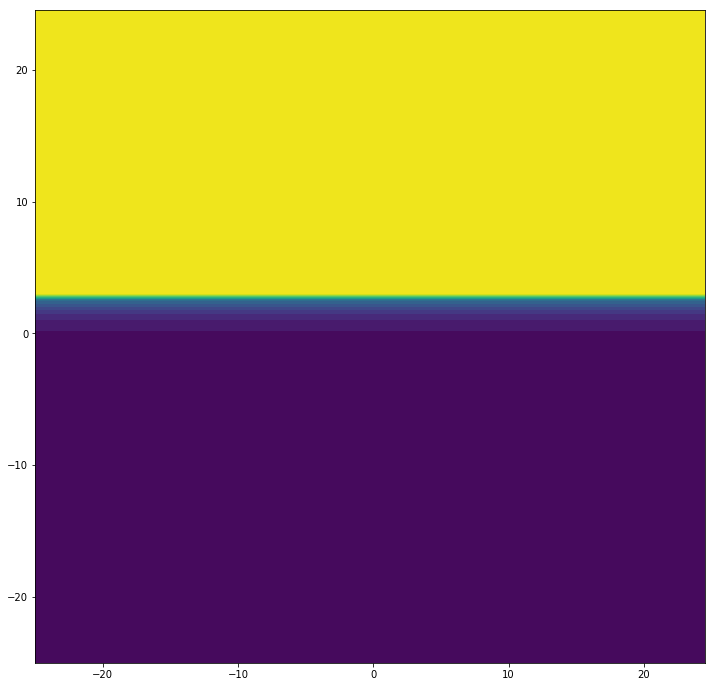

X: layer 0 position (0, 0)
Y: layer 2 position (0, 1)


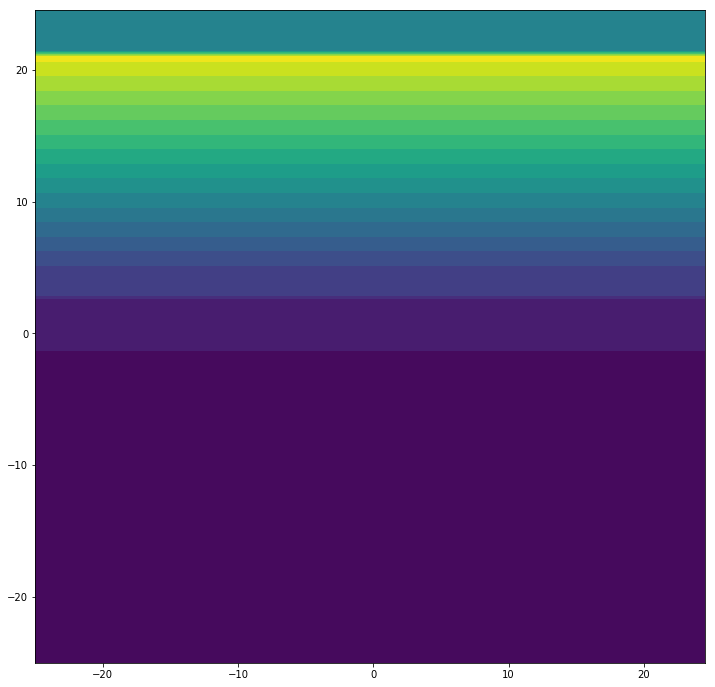

X: layer 0 position (0, 1)
Y: layer 0 position (1, 0)


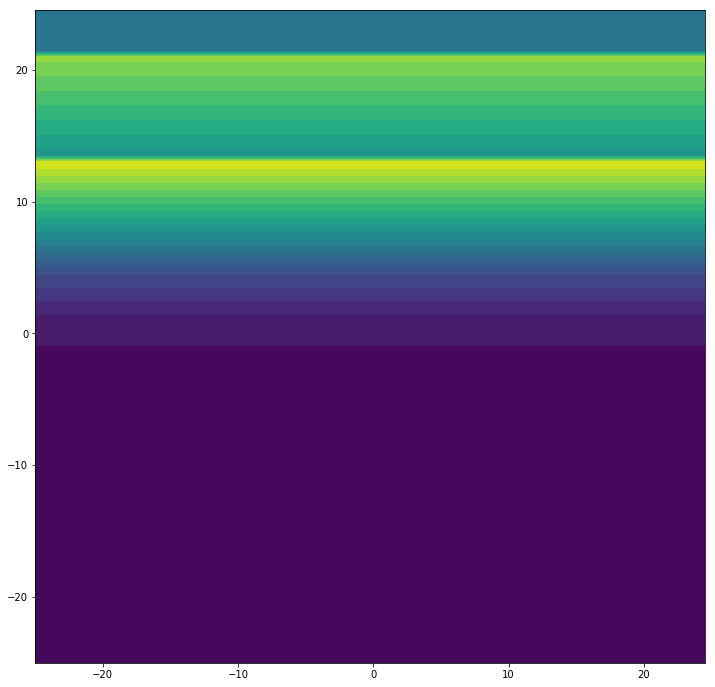

X: layer 0 position (0, 1)
Y: layer 0 position (1, 1)


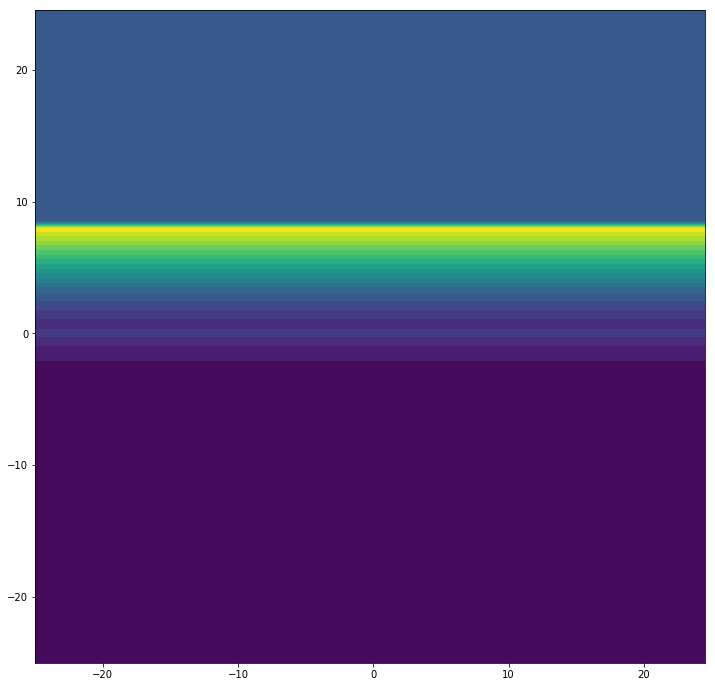

X: layer 0 position (0, 1)
Y: layer 2 position (0, 0)


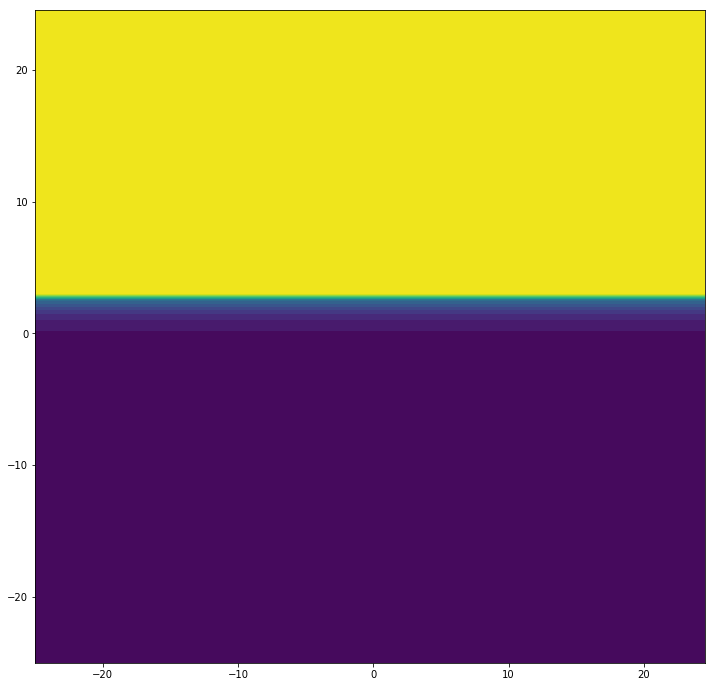

X: layer 0 position (0, 1)
Y: layer 2 position (0, 1)


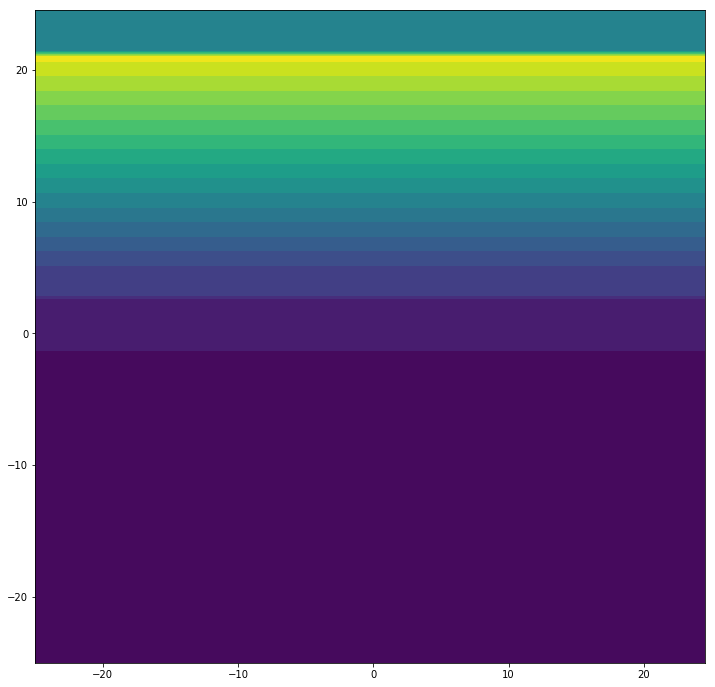

X: layer 0 position (1, 0)
Y: layer 0 position (1, 1)


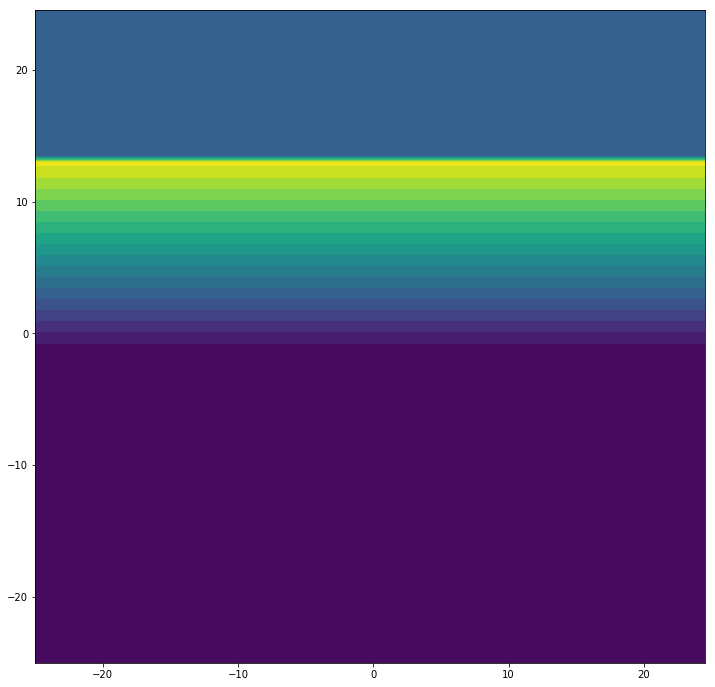

X: layer 0 position (1, 0)
Y: layer 2 position (0, 0)


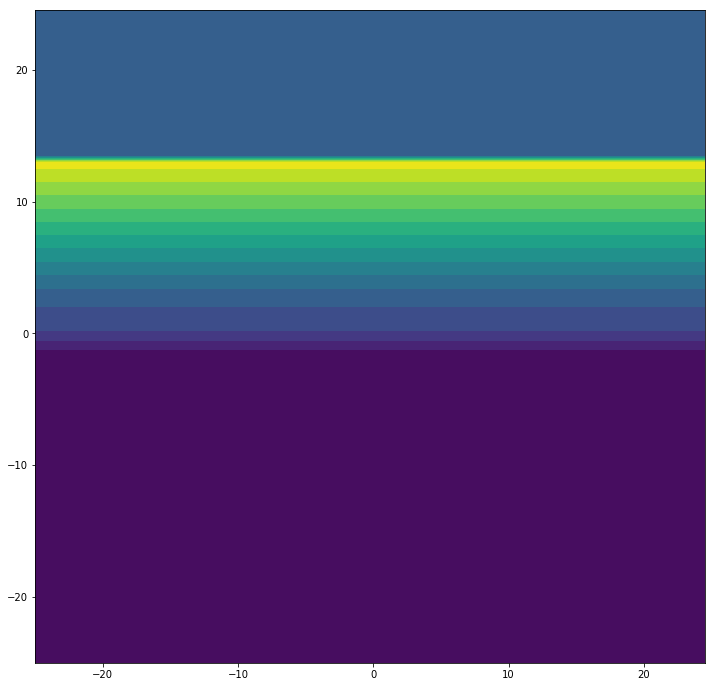

X: layer 0 position (1, 0)
Y: layer 2 position (0, 1)


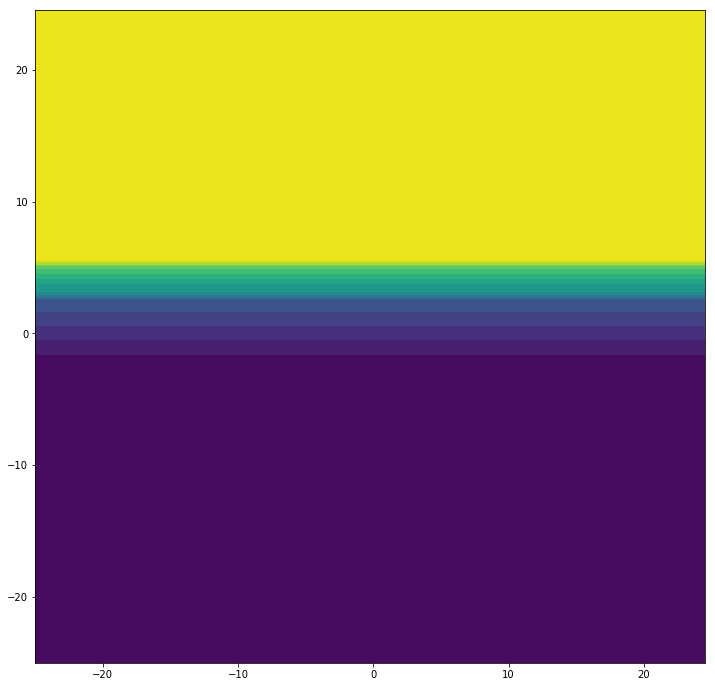

X: layer 0 position (1, 1)
Y: layer 2 position (0, 0)


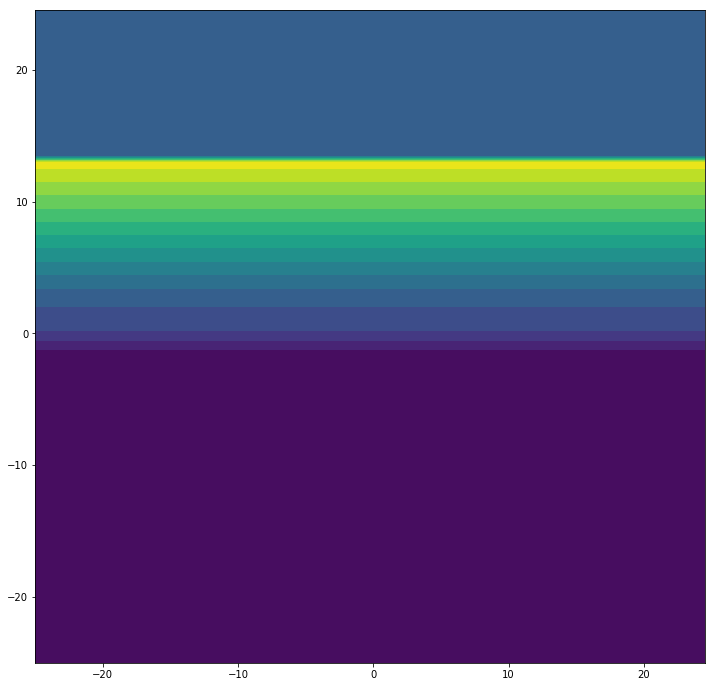

X: layer 0 position (1, 1)
Y: layer 2 position (0, 1)


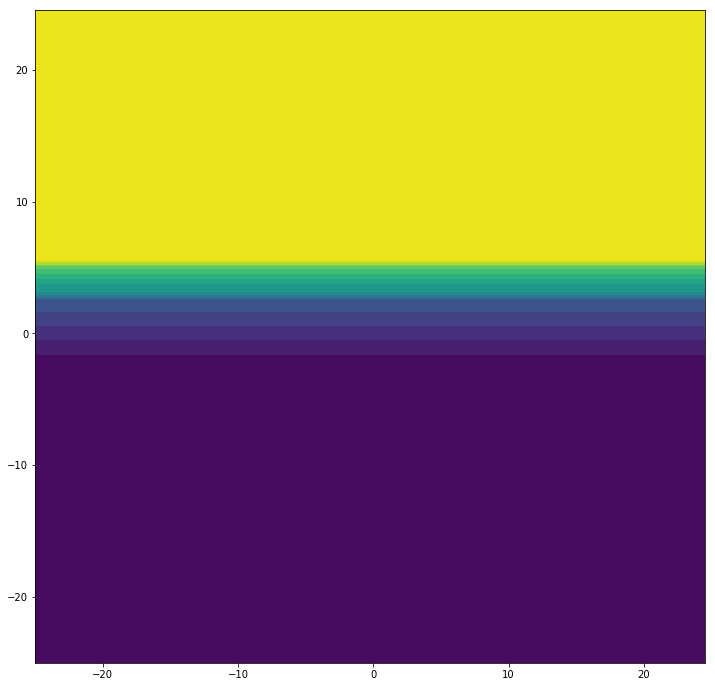

X: layer 2 position (0, 0)
Y: layer 2 position (0, 1)


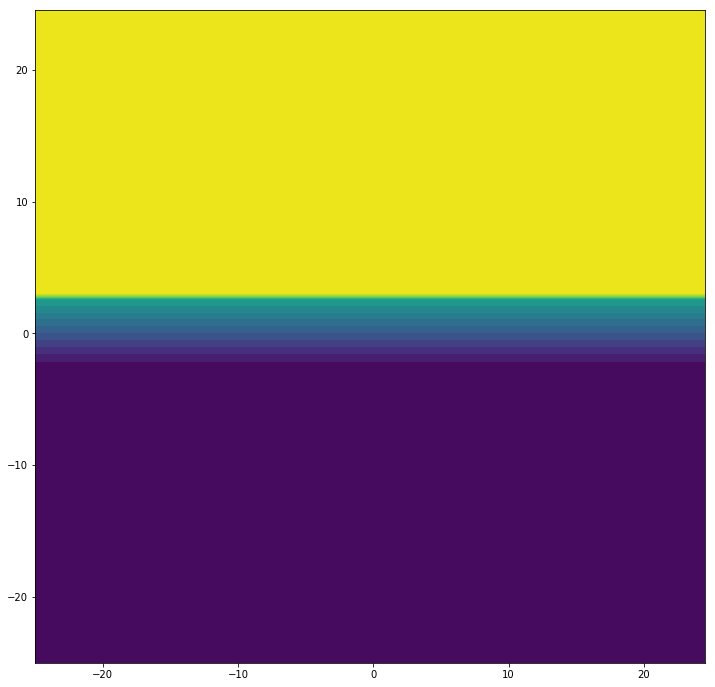

In [230]:
"""
Displaying the loss as contour map, for each of the neurons
"""

import copy

def contour_map(original_model):        
    inputs = torch.tensor([[0, 0], [1, 0], [0, 1], [1, 1]], dtype=torch.long, requires_grad=False)
    expected = torch.tensor([0, 1, 1, 0], dtype=torch.float, requires_grad=False)
    criterion = nn.BCELoss()
    
    X = np.arange(-25.0, 25.0, 0.5)
    Y = np.arange(-25.0, 25.0, 0.5)
    n = len(X)
    m = len(Y)
    
    axes = [
        (0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), # Layer 1
        (2, 0, 0), (2, 0, 1)                        # Layer 2
    ]
    for axe_i in range(len(axes)):
        for axe_j in range(axe_i + 1, len(axes)):
            model = XORModel()
            model.load_state_dict(copy.deepcopy(original_model.state_dict()))
            model.eval()
            
            a, b, c = axes[axe_i]
            d, e, f = axes[axe_j]
            
            print("X: layer", a, "position", (b, c))
            print("Y: layer", d, "position", (e, f))
            
            losses = np.zeros(n * m).reshape((n, m))
            for i in range(n):
                for j in range(m):
                    model.model[a].weight[(b, c)] = X[i]
                    model.model[d].weight[(e, f)] = Y[i]
                    losses[(i, j)] = criterion(model(inputs), expected)

            fig, ax = plt.subplots(figsize=(12, 12))
            CS = ax.contourf(X, Y, losses, levels=20, linewidths=3, antialiased=True)
            # ax.clabel(CS, inline=1, fontsize=14)
            plt.show()

contour_map(model2)